# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1388]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [753]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Business Understanding

Through this capstone project I want to understand the following:
1. How does offer response depend on gender, age and income? 
2. What type of demographic is least affected by offers?
3. What are the top 2 offers for each customer segment?
4. If we're given demographic features about a customer, how can we determine if they'll respond to a BOGO or a discount offer?

## Data Understanding

### Understanding the build of the dataframes

In [754]:
# Find out shape of the different dataframes
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)

(10, 6)
(17000, 5)
(306534, 4)


In [1288]:
print(portfolio.info())
print(profile.info())
print(transcript.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None
<class 'panda

In [759]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [760]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [761]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [755]:
# Understand Columns of the different dataframes
print(portfolio.columns)
print(profile.columns)
print(transcript.columns)

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')
Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')
Index(['person', 'event', 'value', 'time'], dtype='object')


In [756]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [757]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [758]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


## Data Preparation

### Data Cleaning

In [762]:
def clean_transcript(df):
    """
    Cleans the transcript dataframe with the following actions:
    1. Renames person column to customer_id
    2. Creates dummies for the event column
    3. Creates separate columns for offer id and transaction amount
    4. Deletes the event and value column
    Input:
    original unclean df
    Output
    clean_df
    """
    clean_df = df.copy()
    clean_df.event = clean_df.event.str.replace(" ", "_")
    clean_df = pd.get_dummies(clean_df, prefix= "event", columns=["event"])
    clean_df["offer_id"] = [next(iter(i.items()))[1] if (next(iter(i.items()))[0] == "offer id") | 
                            (next(iter(i.items()))[0] == "offer_id") else None for i in clean_df.value]
    clean_df["txn_amount"] = [next(iter(i.items()))[1] if next(iter(i.items()))[0] == "amount" 
                              else None for i in clean_df.value]
    clean_df.drop(columns = "value", inplace = True)
    clean_df.rename(columns={'person':'customer_id'}, inplace=True)
    return clean_df

In [763]:
a = clean_transcript(transcript)

In [764]:
a.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,txn_amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [765]:
def clean_profile(df):
    """
    Cleans the profile dataframe with the following actions:
    1. Renames id column to customer_id
    2. Removes outliers from the age column
    3. Creates dummies for the gender column
    4. Formats the time column to convert from string to datetime
    Input:
    original unclean df
    Output
    clean_df
    """
    clean_df = df.copy()
    clean_df.rename(columns = {"id": "customer_id"}, inplace = True)
    q = clean_df["age"].quantile(0.95)
    clean_df = clean_df.loc[clean_df["age"] < q]
    #clean_df = pd.get_dummies(clean_df, prefix= "gender", columns=["gender"])
    date = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
    clean_df.became_member_on = clean_df.became_member_on.apply(date)
    return clean_df

In [766]:
b = clean_profile(profile)

In [767]:
b.head()

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [768]:
def clean_portfolio(df):
    """
    Cleans the profile dataframe with the following actions:
    1. Renames id column to offer_id
    2. Creates dummy columns for channels column
    3. Removes the channels column
    Input:
    original unclean df
    Output
    clean_df
    """
    clean_df = df.copy()
    clean_df.rename(columns = {"id": "offer_id"}, inplace = True)
    x = pd.get_dummies(clean_df['channels'].explode()).sum(level=0)
    clean_df = pd.concat([clean_df, x], axis=1, sort=False)
    clean_df.drop(columns = ["channels"], inplace = True)
    return clean_df

In [769]:
c = clean_portfolio(portfolio)

In [916]:
c

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


### Data Merging

In [771]:
def merge_dataframes(a,b,c):
    merge_1 = pd.merge(a, b, on='customer_id', how="left")
    merge_2 = pd.merge(merge_1, c, on='offer_id', how='left')
    offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'B1',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'B2',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'B3',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'B4',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'D1',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'D2',
                'fafdcd668e3743c1bb461111dcafc2a4': 'D3',
                '2906b810c7d4411798c6938adc9daaa5': 'D4',
                '3f207df678b143eea3cee63160fa8bed': 'I1',
                '5a8bc65990b245e5a138643cd4eb9837': 'I2'}
    merge_2.offer_id = merge_2.offer_id.apply(lambda x: offer_id[x] if x else None)
    return merge_2

In [772]:
d = merge_dataframes(a,b,c)

In [773]:
#profile dataframe has fewer customer ids than transcript df so dropping nan values from the merged dataframe
d.dropna(subset = ["age"], inplace = True)

## Data Analysis

In this project, I'm not going to do any modelling - I simply want to analyze the dataset and make a set of recommendations

### Overall Experiment Information

In [774]:
#How long was the experiment run with offers?
clean_df = d.copy()
print("The offer data is over a period of {} days".format(clean_df.time.max()/24))

The offer data is over a period of 29.75 days


In [775]:
clean_df.customer_id.nunique()

14825

In [777]:
#How many offers were sent to the customer?
print("Total number of offers were {}".format(clean_df.offer_id.nunique()))

Total number of offers were 10


In [778]:
#Offer Success Rate
offer_r = len(clean_df.loc[clean_df.event_offer_received == 1])
offer_c = len(clean_df.loc[clean_df.event_offer_completed == 1])
print("Overall offer success rate was {:.1f}%".format(offer_c/offer_r*100))

Overall offer success rate was 48.8%


In [779]:
#Please refer to analysis below. Excluding I1 and I2 from the analysis because those offers are only informational
condition1 = clean_df.offer_id != "I1"
condition2 = clean_df.offer_id != "I2"
condition3 = clean_df.event_offer_received == 1
offer_r1 = len(clean_df.loc[condition1 & condition2 & condition3])
print("Overall offer success rate was {:.1f}%".format(offer_c/offer_r1*100))

Overall offer success rate was 61.0%


We need to calculate the offer success rate by excluding the I1 and I2 offers because they are informational and can't be completed
by the customer. Hence, including them will underreport the success rate as you can see from the cells above

In [780]:
#What is the sample size of the data?
print("The merged dataset has a sample of {} customers".format(clean_df.customer_id.nunique()))

The merged dataset has a sample of 14825 customers


### Offer Analysis

In [781]:
#Grouping the Dataset by order_id to determine offer performance
offer = clean_df.groupby(["offer_id"]).agg({"event_offer_received":"sum", "event_offer_viewed":"sum", "event_offer_completed":"sum"})
offer.loc[:,"receive_view_ratio"] = offer.event_offer_viewed/offer.event_offer_received
offer.loc[:,"receive_complete_ratio"] = offer.event_offer_completed/offer.event_offer_received

In [782]:
offer.head()

,event_offer_received,event_offer_viewed,event_offer_completed,receive_view_ratio,receive_complete_ratio
offer_id,,,,,
B1,6683.0,5901.0,3657.0,0.882987,0.547209
B2,6593.0,6329.0,3310.0,0.959958,0.502048
B3,6685.0,3499.0,4188.0,0.523411,0.626477
B4,6576.0,6310.0,4103.0,0.959550,0.623936
D1,6726.0,2215.0,3386.0,0.329319,0.503420


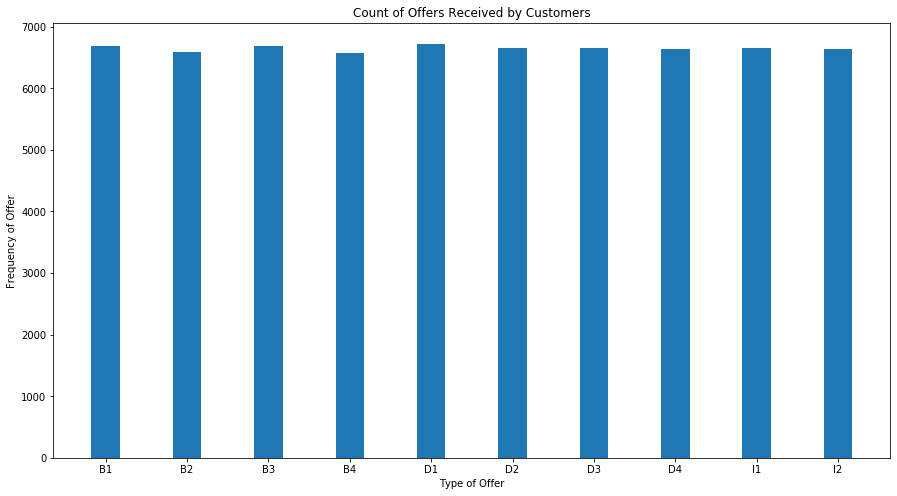

In [783]:
plt.figure(figsize = (15,8))
plt.bar(offer.index, offer.event_offer_received, width = 0.35)
plt.xlabel("Type of Offer")
plt.ylabel("Frequency of Offer")
plt.title("Count of Offers Received by Customers")
plt.show()

It seem like offers were generated uniformly and sent to the customers since the frequency is almost the same

In [784]:
#Preparing an autolabel function to label the next few graphs
def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        #print(height)
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2, label_position,
                '%.2f' % float(height),
                ha='center', va='bottom')

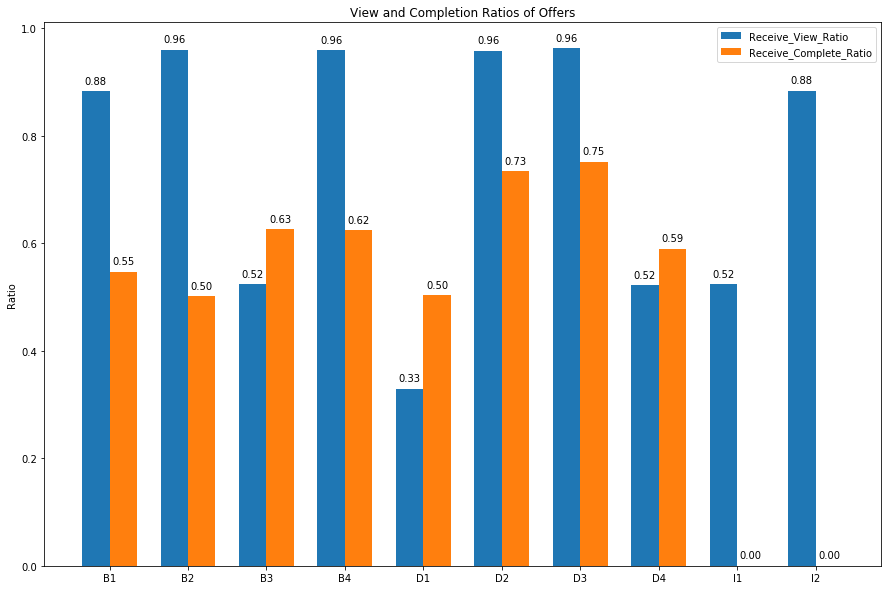

In [785]:
#Below chart shows the receive to view ratio and the receive to completion ratio
labels = offer.index.tolist()
bar1 = offer.receive_view_ratio.tolist()
bar2 = offer.receive_complete_ratio.tolist()
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (15,10))
rects1 = ax.bar(x - width/2, bar1, width, label='Receive_View_Ratio')
rects2 = ax.bar(x + width/2, bar2, width, label='Receive_Complete_Ratio')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Ratio')
ax.set_title('View and Completion Ratios of Offers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1, ax)
autolabel(rects2, ax)

plt.show()

As you can see from the graph, the two most succesful offers were D2 and D3 with a 96% view rate and a ~75% completion rate. On the other hand, as the names suggest, I1 and I2 were just informational offers with no completion. For this analysis, we will ignore I1 and I2.

### Customer Analysis

#### Gender Analysis

In [82]:
gender = clean_df.groupby("gender").agg({"customer_id":"nunique"})
gender.loc[:,"%_total"] = gender.customer_id/gender.customer_id.sum()
gender

,customer_id,%_total
gender,,
F,6129,0.413423
M,8484,0.572277
O,212,0.014300


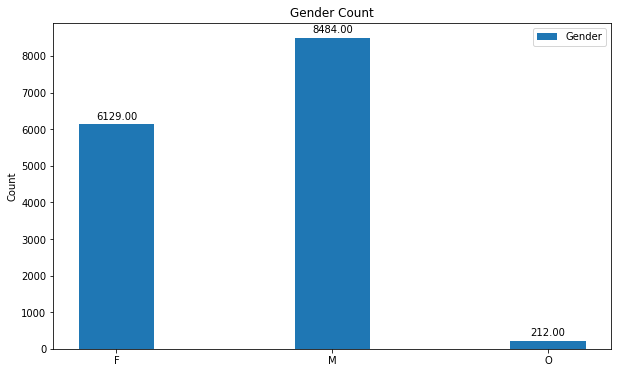

In [1273]:
gender_labels = gender.index.tolist()
gender_len = np.arange(len(gender_labels))
gender_bar = gender.customer_id.tolist()
fig, ax = plt.subplots(figsize = (10,6))
gender_rects = ax.bar(gender_len, gender_bar, width, label = "Gender")


ax.set_ylabel('Count')
ax.set_title('Gender Count')
ax.set_xticks(gender_len)
ax.set_xticklabels(gender_labels)
ax.legend()

autolabel(gender_rects, ax)

plt.show()

From the table, we can see that the dataset has ~57% males, ~41% females and ~1.5% other. For the analysis, we will exclude gender "O" from our analysis

#### Age Analysis

In [787]:
age = clean_df.groupby(pd.cut(clean_df.age, range(int(clean_df.age.min())-1, int(clean_df.age.max()+11), 10))).agg({"customer_id":"nunique"})
age.loc[:,"%_total"] = age.customer_id/age.customer_id.sum()
age.loc[:,"%_cum"] = age["%_total"].cumsum()
age

,customer_id,%_total,%_cum
age,,,
"(17, 27]",1308,0.088229,0.088229
"(27, 37]",1438,0.096998,0.185228
"(37, 47]",2054,0.138550,0.323777
"(47, 57]",3383,0.228196,0.551973
"(57, 67]",3257,0.219696,0.771669
"(67, 77]",2031,0.136998,0.908668
"(77, 87]",966,0.065160,0.973828
"(87, 97]",361,0.024351,0.998179
"(97, 107]",27,0.001821,1.000000


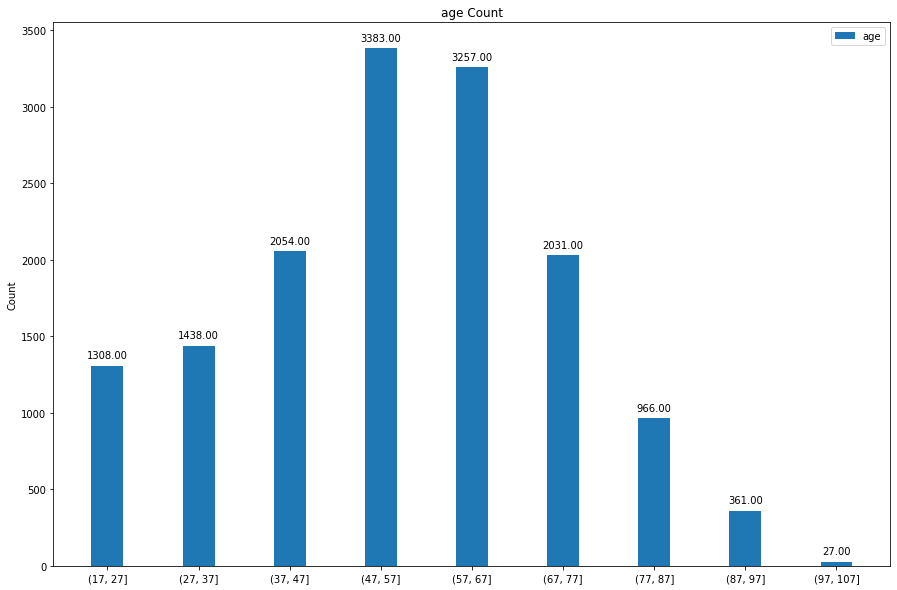

In [788]:
age_labels = age.index.tolist()
age_len = np.arange(len(age_labels))
age_bar = age.customer_id.tolist()
fig, ax = plt.subplots(figsize = (15,10))
age_rects = ax.bar(age_len, age_bar, width, label = "age")


ax.set_ylabel('Count')
ax.set_title('age Count')
ax.set_xticks(age_len)
ax.set_xticklabels(age_labels)
ax.legend()

autolabel(age_rects, ax)

plt.show()

From the table we can see that ~44% of the customers fall within the age bracket between 47 and 67

#### Income Analysis

In [790]:
income = clean_df.groupby(pd.cut(clean_df.income, range(int(clean_df.income.min()-10000), int(clean_df.income.max())+10000, 10000))).agg({"customer_id":"nunique"})
income.loc[:,"%_total"] = income.customer_id/income.customer_id.sum()
income.loc[:,"%_cum"] = income["%_total"].cumsum()
income

,customer_id,%_total,%_cum
income,,,
"(20000, 30000]",88,0.005936,0.005936
"(30000, 40000]",2047,0.138078,0.144013
"(40000, 50000]",1899,0.128094,0.272108
"(50000, 60000]",2659,0.179359,0.451467
"(60000, 70000]",2347,0.158314,0.609781
"(70000, 80000]",2220,0.149747,0.759528
"(80000, 90000]",1371,0.092479,0.852007
"(90000, 100000]",1188,0.080135,0.932142
"(100000, 110000]",546,0.036830,0.968971


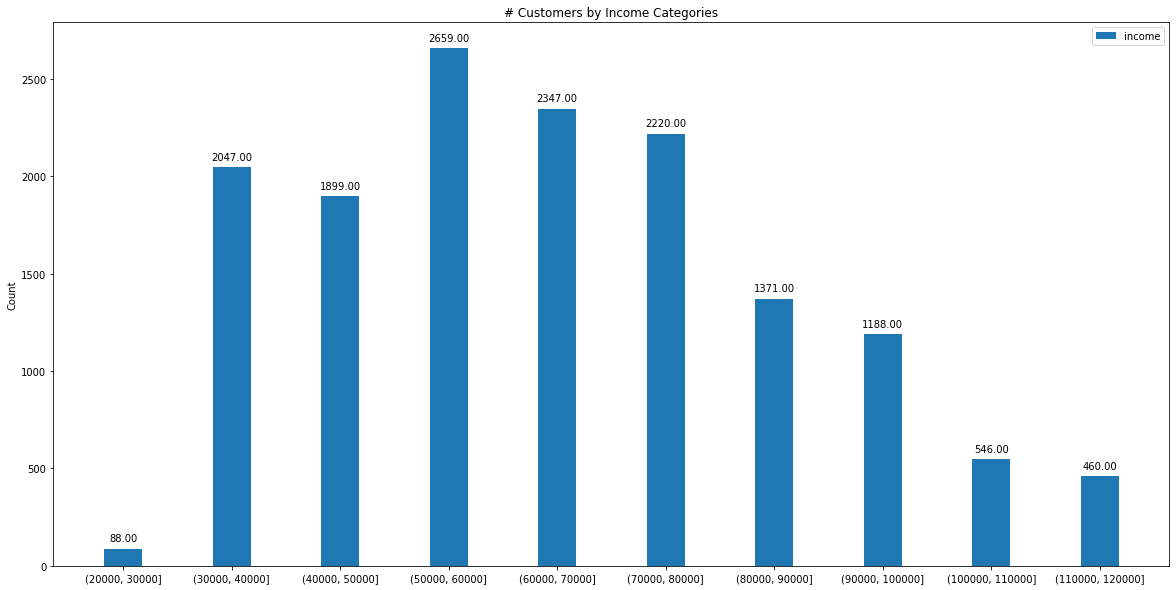

In [791]:
income_labels = income.index.tolist()
income_len = np.arange(len(income_labels))
income_bar = income.customer_id.tolist()
fig, ax = plt.subplots(figsize = (20,10))
income_rects = ax.bar(income_len, income_bar, width, label = "income")


ax.set_ylabel('Count')
ax.set_title('# Customers by Income Categories')
ax.set_xticks(income_len)
ax.set_xticklabels(income_labels)
ax.legend()

autolabel(income_rects, ax)

plt.show()

### Income, Age and Gender Analysis

In [850]:
#Removing gender "O" and "I1 and I2" from the data
helper_df = clean_df.copy()
gender_condition = helper_df.gender != "O"
offer_condition1 = helper_df.offer_id != "I1"
offer_condition2 = helper_df.offer_id != "I2"
helper_df = helper_df.loc[gender_condition & offer_condition1 & offer_condition2]

In [793]:
helper_df.customer_id.nunique()

14610

After removing gender "O" and offers "I1" and "I2", the new dataset has 14,610 unique customers

In [794]:
age_bins = list(np.arange(18,118,10))
income_bins = list(np.arange(30000,130000,10000))
age_labels = ['{}-{}'.format(i, j) for i, j in zip(age_bins[:-1], age_bins[1:])]
income_labels = ['{}-{}'.format(i, j) for i, j in zip(income_bins[:-1], income_bins[1:])]
helper_df.age = pd.cut(clean_df.age, bins = age_bins, labels = age_labels)
helper_df.income = pd.cut(clean_df.income, bins = income_bins, labels = income_labels)

In [795]:
gender_age = helper_df.groupby(["gender", "age"]).agg({"event_offer_completed":"sum", "event_offer_received":"sum"})

In [796]:
gender_income = helper_df.groupby(["gender", "income"]).agg({"event_offer_completed":"sum", "event_offer_received":"sum"})

In [797]:
gender_income.loc[:,"completion_%"] = gender_income.event_offer_completed/gender_income.event_offer_received

In [798]:
gender_age.loc[:,"completion_%"] = gender_age.event_offer_completed/gender_age.event_offer_received

In [179]:
new_df = helper_df.copy()

In [180]:
new_df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,txn_amount,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,B3,NaN,F,68-78,2017-05-09,90000-100000,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,D4,NaN,M,58-68,2018-04-26,60000-70000,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
5,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,B4,NaN,M,58-68,2018-02-09,50000-60000,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,D1,NaN,F,58-68,2017-09-11,50000-60000,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
9,31dda685af34476cad5bc968bdb01c53,0,0,1,0,0,D1,NaN,F,58-68,2016-02-11,70000-80000,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0


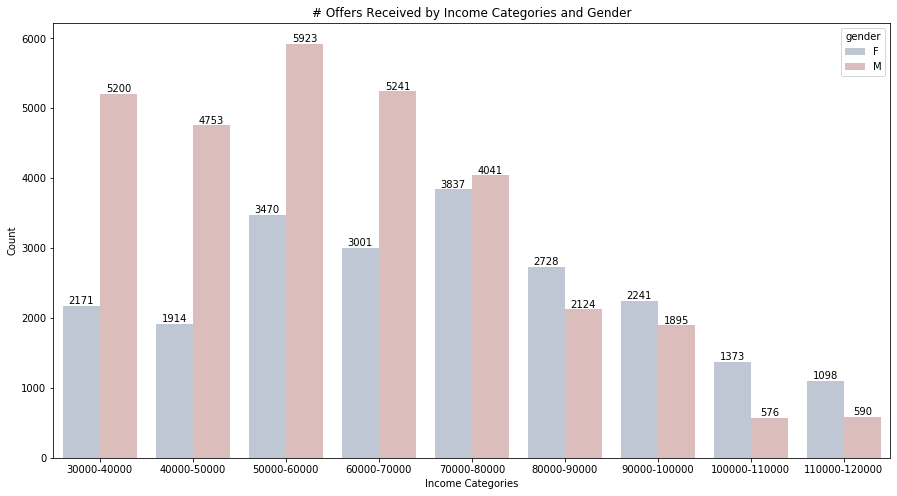

In [799]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x = "income", y = "event_offer_received", hue = "gender", data = gender_income.reset_index(), palette = "vlag")
ax.set_xlabel("Income Categories")
ax.set_ylabel("Count")
ax.set_title("# Offers Received by Income Categories and Gender")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

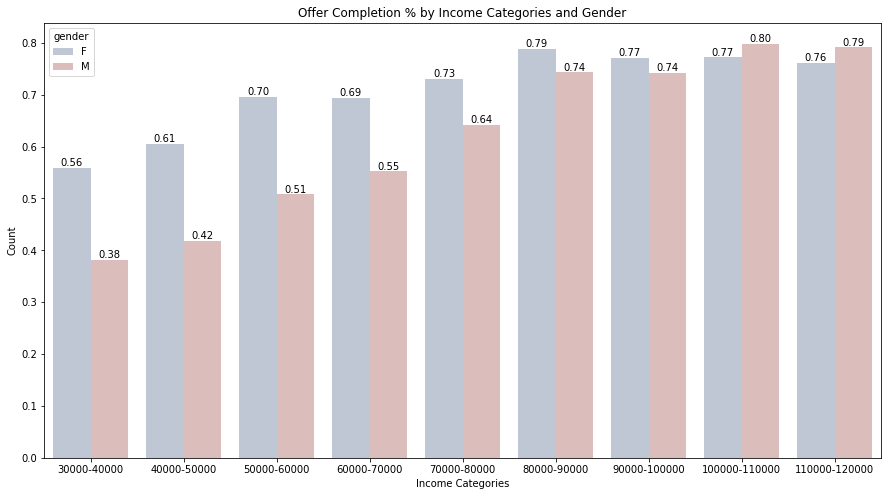

In [800]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x = "income", y = "completion_%", hue = "gender", data = gender_income.reset_index(), palette = "vlag")
ax.set_xlabel("Income Categories")
ax.set_ylabel("Count")
ax.set_title("Offer Completion % by Income Categories and Gender")
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

As you can see from the graphs and tables above, offer completion % increases as the income level increases however offers received by the higher income levels is much lesser than that of the lower income levels. This might be due to the fact that there are fewer customers in the higher income brackets as you can see in the graph above. However, Starbucks needs to ensure that the higher level income brackets receive more offers per customer than they do currently. This doesn't really mean that the higher income levels respond better to offers. 

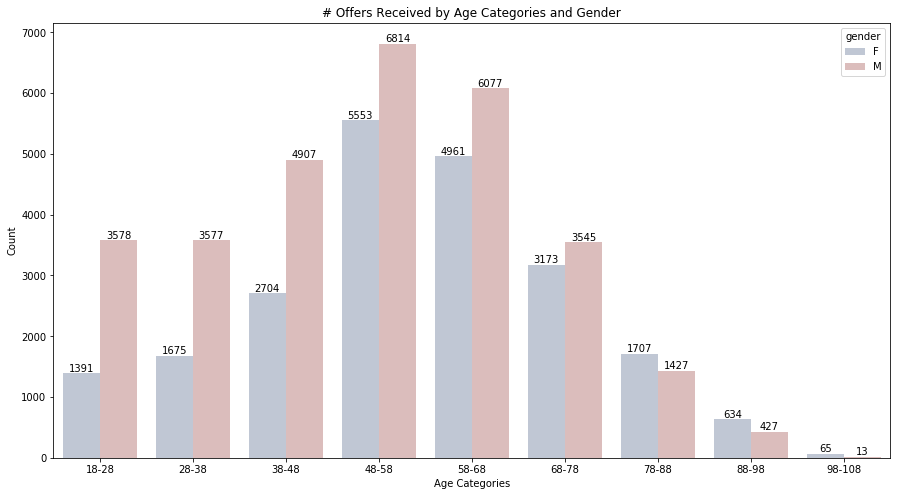

In [801]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x = "age", y = "event_offer_received", hue = "gender", data = gender_age.reset_index(), palette = "vlag")
ax.set_xlabel("Age Categories")
ax.set_ylabel("Count")
ax.set_title("# Offers Received by Age Categories and Gender")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

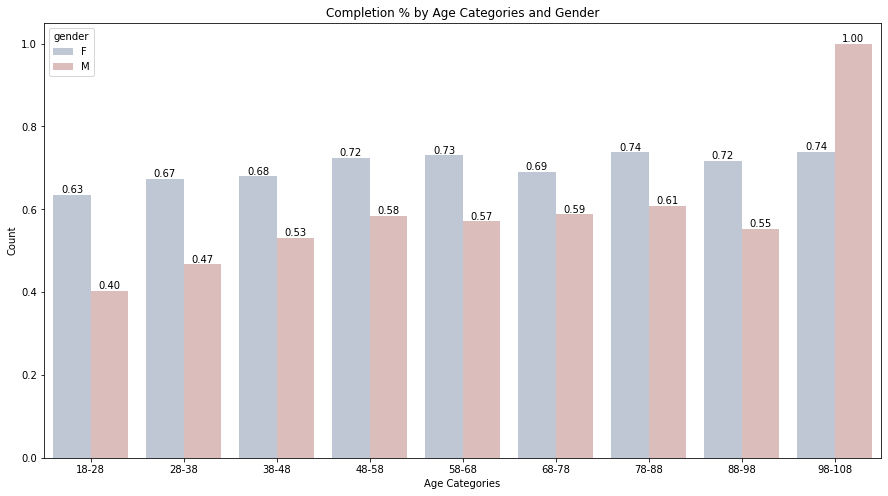

In [802]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x = "age", y = "completion_%", hue = "gender", data = gender_age.reset_index(), palette = "vlag")
ax.set_xlabel("Age Categories")
ax.set_ylabel("Count")
ax.set_title("Completion % by Age Categories and Gender")
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

From the graph above, we can see that females have better offer completion rates than men

### Preparing the Customer Dataframe

In [803]:
customer_df = helper_df.copy()

In [804]:
condition = customer_df.event_offer_completed == 1
h1 = customer_df.loc[condition].groupby("customer_id").agg({"event_offer_completed":"sum", 
                                                            "difficulty":"sum", "reward":"sum"})

In [805]:
h2 = customer_df.groupby("customer_id").agg({"txn_amount":"sum"})

In [806]:
merge_customer = pd.merge(h1, h2, on = "customer_id")

In [807]:
merge_customer.loc[:,"txn_dif_ratio"] = merge_customer.txn_amount/merge_customer.difficulty

In [808]:
merge_customer.txn_dif_ratio.max()

210.81199999999998

In [809]:
merge_customer.event_offer_completed.corr(merge_customer.txn_amount)

0.43319342780020875

There's a decent correlation between the # offers completed and the total amount spent by a customer

In [814]:
(merge_customer.txn_dif_ratio >=5).sum()

5388

From the above cell, we can see that there are ~5400 customers who have spent more than 5 times of the sum of offer difficulties added together.
These are customers we can assume will spend regardless of receiving a particular offer. Hence for this subset of customers, we can send fewer offers
per customer when compared to the subset whose spend is less than 5 times the sum of offer difficulties

In [843]:
clean_customer_df = helper_df.groupby("customer_id").agg({"event_offer_received":"sum", "event_offer_completed":"sum",
                                                         "event_transaction":"sum", "txn_amount":"sum"})

In [ ]:
helper_df = helper_df.set_index("customer_id")

In [852]:
clean_customer_df = pd.merge(clean_customer_df,helper_df[['customer_id','gender', "age", "income", "became_member_on"]],on='customer_id', how='left').drop_duplicates(subset = ["customer_id"], keep="first")

In [855]:
h3 = helper_df.loc[helper_df.event_offer_completed == 1].groupby(["customer_id"])["offer_id"].value_counts().
unstack(fill_value = 0)

In [857]:
h3.reset_index(inplace = True)

In [859]:
clean_customer_df = pd.merge(clean_customer_df,h3[['customer_id', 'B1', 'B2', 'B3', 'B4', 'D1', 'D2', 'D3', 'D4']],
                             on='customer_id', how='left')

In [861]:
clean_customer_df.fillna(0, inplace = True)

In [862]:
clean_customer_df = clean_customer_df.astype({'B1':'int', 'B2': 'int',
                                             'B3':'int', 'B4': 'int',
                                             'D1':'int', 'D2': 'int',
                                             'D3':'int', 'D4': 'int',
                                             "age":"int", "income":"int",
                                             "txn_amount":"int"})

In [865]:
merge_customer.reset_index(inplace = True)

In [866]:
clean_customer_df = pd.merge(clean_customer_df,merge_customer[['customer_id', 'difficulty', 'reward', 'txn_dif_ratio']],
                             on='customer_id', how='left')

In [867]:
clean_customer_df.fillna(0, inplace = True)

In [868]:
clean_customer_df = clean_customer_df.astype({"difficulty":"int", "reward":"int",
                                             "txn_dif_ratio":"float"})

In [869]:
clean_customer_df.loc[:,"txn_dif_ratio"] = clean_customer_df.txn_amount/clean_customer_df.difficulty

In [577]:
clean_customer_df.txn_dif_ratio.fillna(1000, inplace = True)

For customers who didn't complete any offers but had transactions will have nan values or inf values so changing them to 1000

In [971]:
#Removing customers over age 80 based on the value counts in the above cell
clean_customer_df = clean_customer_df.loc[clean_customer_df.age <= 80]

In [ ]:
clean_customer_df.loc[(clean_customer_df.txn_dif_ratio > 0) & (clean_customer_df.txn_dif_ratio <= 2), "offer_responsiveness"] = "high"
clean_customer_df.loc[(clean_customer_df.txn_dif_ratio > 2) & (clean_customer_df.txn_dif_ratio <= 10), "offer_responsiveness"] = "medium"
clean_customer_df.loc[(clean_customer_df.txn_dif_ratio > 10), "offer_responsiveness"] = "low"

To solve the problem for whether a customer actually intended to complete the offer when the offer was completed, I'm segmenting the customer
based on their transaction amount and offer difficulty. If the ratio of transaction amount to offer difficulty is very low 

In [1275]:
clean_customer_df.offer_responsiveness.value_counts(normalize = True)

medium    0.635176
low       0.281166
high      0.083659
Name: offer_responsiveness, dtype: float64

In [1078]:
age_customer_bins = clean_customer_df.age.value_counts(bins = 5).index

In [1022]:
income_customer_bins = clean_customer_df.income.value_counts(bins = 5).index

In [1025]:
clean_customer_df.loc[:,"age_cat"] = pd.cut(clean_customer_df.age, age_customer_bins)

In [1026]:
clean_customer_df.loc[:,"income_cat"] = pd.cut(clean_customer_df.income, income_customer_bins)

In [1027]:
income_cat_df = clean_customer_df.groupby("income_cat")["offer_responsiveness"].value_counts(normalize = True).mul(100)

In [1028]:
income_cat_df = income_cat_df.rename("percent").reset_index()

In [1029]:
age_cat_df = clean_customer_df.groupby("age_cat")["offer_responsiveness"].value_counts(normalize = True).mul(100)

In [1030]:
age_cat_df = age_cat_df.rename("percent").reset_index()

### Customer Segment Least Affected by Offers

In [1265]:
income_impact = clean_customer_df.groupby(["income_cat", "offer_responsiveness"]).agg({"offer_responsiveness":"count"}).stack()
income_impact = income_impact.reset_index()
income_impact.drop(columns = ["level_2"], inplace = True)
income_impact.rename(columns = {0:"count"}, inplace = True)

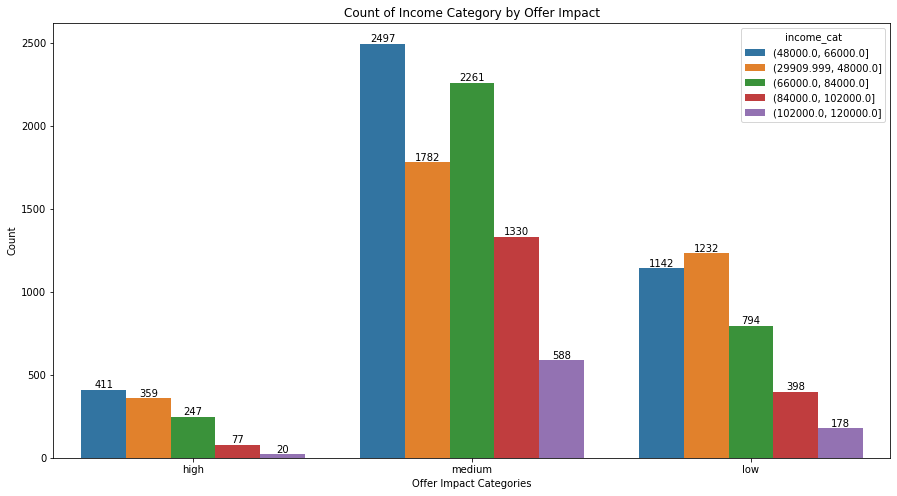

In [1280]:
plt.figure(figsize = (15,8))
ax = sns.barplot(x = "offer_responsiveness", y = "count", hue = "income_cat", data = income_impact, order = ["high", "medium", "low"])
ax.set_xlabel("Offer Impact Categories")
ax.set_ylabel("Count")
ax.set_title("Count of Income Category by Offer Impact")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

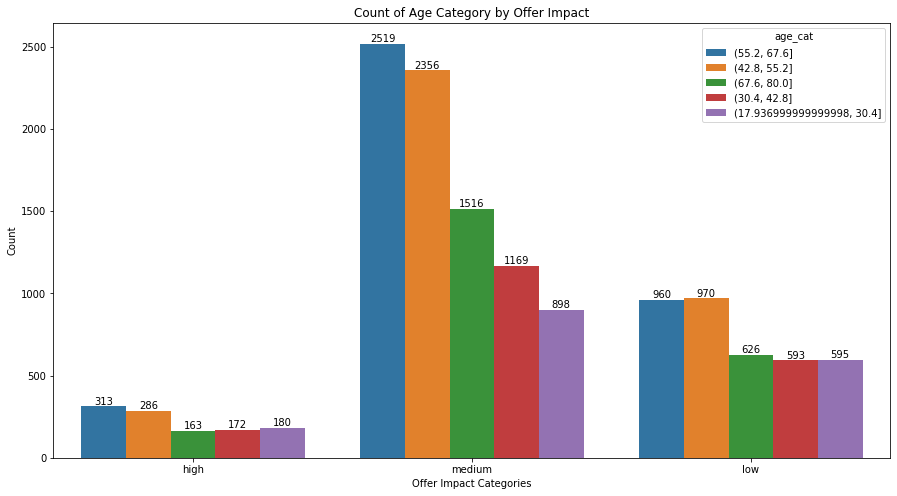

In [1281]:
age_impact = clean_customer_df.groupby(["age_cat", "offer_responsiveness"]).agg({"offer_responsiveness":"count"}).stack()
age_impact = age_impact.reset_index()
age_impact.drop(columns = ["level_2"], inplace = True)
age_impact.rename(columns = {0:"count"}, inplace = True)
plt.figure(figsize = (15,8))
ax = sns.barplot(x = "offer_responsiveness", y = "count", hue = "age_cat", data = age_impact, order = ["high", "medium", "low"])
ax.set_xlabel("Offer Impact Categories")
ax.set_ylabel("Count")
ax.set_title("Count of Age Category by Offer Impact")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

### Offer Heuristics

In the section below, I'm going to segment the customers into a few groups by gender, age and income. I will determine the top 2 offers for each group

In [1070]:
clean_customer_df.age_cat.dtype

CategoricalDtype(categories=[(55.2, 67.6], (42.8, 55.2], (67.6, 80.0], (30.4, 42.8], (17.936999999999998, 30.4]],
              ordered=True)

In [1064]:
offer_heuristics = clean_customer_df.groupby(["gender","age_cat","income_cat"]).agg({"B1":"sum","B2":"sum","B3":"sum","B4":"sum",
                                        "D1":"sum", "D2":"sum", "D3":"sum","D4":"sum"})

In [1065]:
offer_heuristics.loc[:,"bogo_total"] = offer_heuristics.B3 + offer_heuristics.B4 + offer_heuristics.B1 + offer_heuristics.B2

In [1066]:
offer_heuristics.loc[:,"discount_total"] = offer_heuristics.D2 + offer_heuristics.D3 + offer_heuristics.D1 + offer_heuristics.D4

In [1067]:
offer_heuristics.loc[:,"discount_bogo_ratio"] = offer_heuristics.discount_total/offer_heuristics.bogo_total

In [1068]:
offer_heuristics.dropna(axis = 0, inplace = True)

In [1283]:
offer_heuristics.head()

B1     B2     B3     B4     D1  \
gender age_cat      income_cat                                                
F      (55.2, 67.6] (48000.0, 66000.0]    117.0  104.0  121.0  131.0  115.0   
                    (29909.999, 48000.0]   40.0   32.0   55.0   36.0   35.0   
                    (66000.0, 84000.0]    178.0  168.0  172.0  153.0  157.0   
                    (84000.0, 102000.0]   162.0  120.0  148.0  144.0  140.0   
                    (102000.0, 120000.0]   80.0   88.0   60.0   81.0   81.0   

                                             D2     D3     D4  bogo_total  \
gender age_cat      income_cat                                              
F      (55.2, 67.6] (48000.0, 66000.0]    120.0  157.0  111.0       473.0   
                    (29909.999, 48000.0]   63.0   73.0   44.0       163.0   
                    (66000.0, 84000.0]    221.0  232.0  168.0       671.0   
                    (84000.0, 102000.0]   157.0  156.0  149.0       574.0   
                    (102000.0, 120000.0]   86.0   96.0   77.0       309.0   

                                          discount_total  discount_bogo_ratio  
gender age_cat      income_cat                                                 
F      (55.2, 67.6] (48000.0, 66000.0]             503.0             1.063425  
                    (29909.999, 48000.0]           215.0             1.319018  
                    (66000.0, 84000.0]             778.0             1.159463  
                    (84000.0, 102000.0]            602.0             1.048780  
                    (102000.0, 120000.0]           340.0             1.100324

Observation #1: Males react more to discount offers compared to females

Observation #2: B3 and B4 are better bogo offers than B1 and B2

Observation #3: D2 and D3 are better discount offers than D1 and D4

For each of the customer segments, we will list out the top 2 offers they respond to

In [1121]:
top_2_offers = offer_heuristics.loc[:,["B1", "B2", "B3", "B4", "D1", "D2", "D3", "D4"]]

In [1140]:
top_2_offers.loc[:,"Top_2_Offers"] = top_2_offers.apply(lambda s, n: s.nlargest(n).index.tolist(), axis=1, n=2).values

In [1284]:
top_2_offers.reset_index()

,gender,age_cat,income_cat,B1,B2,B3,B4,D1,D2,D3,D4,Top_2_Offers
0,F,"(55.2, 67.6]","(48000.0, 66000.0]",117.0,104.0,121.0,131.0,115.0,120.0,157.0,111.0,"[D3, B4]"
1,F,"(55.2, 67.6]","(29909.999, 48000.0]",40.0,32.0,55.0,36.0,35.0,63.0,73.0,44.0,"[D3, D2]"
2,F,"(55.2, 67.6]","(66000.0, 84000.0]",178.0,168.0,172.0,153.0,157.0,221.0,232.0,168.0,"[D3, D2]"
3,F,"(55.2, 67.6]","(84000.0, 102000.0]",162.0,120.0,148.0,144.0,140.0,157.0,156.0,149.0,"[B1, D2]"
4,F,"(55.2, 67.6]","(102000.0, 120000.0]",80.0,88.0,60.0,81.0,81.0,86.0,96.0,77.0,"[D3, B2]"
5,F,"(42.8, 55.2]","(48000.0, 66000.0]",125.0,104.0,128.0,140.0,117.0,164.0,151.0,145.0,"[D2, D3]"
6,F,"(42.8, 55.2]","(29909.999, 48000.0]",35.0,34.0,70.0,59.0,36.0,61.0,61.0,45.0,"[B3, D2]"
7,F,"(42.8, 55.2]","(66000.0, 84000.0]",131.0,142.0,154.0,124.0,131.0,149.0,152.0,151.0,"[B3, D3]"
8,F,"(42.8, 55.2]","(84000.0, 102000.0]",121.0,122.0,103.0,116.0,99.0,112.0,112.0,99.0,"[B2, B1]"
9,F,"(42.8, 55.2]","(102000.0, 120000.0]",36.0,49.0,63.0,51.0,42.0,49.0,68.0,46.0,"[D3, B3]"


## Machine Learning Model

### Model Data Prep

In [1373]:
def ml_model_prep(df):
    """
    1. Determines if a particular offer is bogo or discount
    2. Drops all NaN values from the dataset
    3. Groups the dataframe by customer_id and offer_type
    """
    df = df.copy()
    
    #conditions for filtering
    bogo_condition = ((df.offer_id == "B1") | (df.offer_id == "B2") | 
                      (df.offer_id == "B3") | (df.offer_id == "B4"))
    discount_condition = ((df.offer_id == "D1") | (df.offer_id == "D2") | 
                          (df.offer_id == "D3") | (df.offer_id == "D4"))
    
    #Filling column offer_type based on conditions above
    df.loc[bogo_condition,"offer_type"] = "bogo"
    df.loc[discount_condition,"offer_type"] = "discount"
    
    #dropping all NaNs from the dataset
    df.dropna(subset=['offer_id'] ,inplace=True)
    
    revised_df = df.groupby(['customer_id' , 'offer_type']).agg({
         'event_offer_completed':sum,   
         'event_offer_received': sum, 
         'event_offer_viewed': sum,  
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last'
    }).reset_index()
    
    return revised_df

In [1374]:
model_prep = ml_model_prep(helper_df)

In [1375]:
model_prep.head()

,customer_id,offer_type,event_offer_completed,event_offer_received,event_offer_viewed,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,bogo,1,1,1,33.0,2017-04-21,M,72000.0
1,0009655768c64bdeb2e877511632db8f,discount,2,2,1,33.0,2017-04-21,M,72000.0
2,0020c2b971eb4e9188eac86d93036a77,bogo,1,2,1,59.0,2016-03-04,F,90000.0
3,0020c2b971eb4e9188eac86d93036a77,discount,2,2,1,59.0,2016-03-04,F,90000.0
4,0020ccbbb6d84e358d3414a3ff76cffd,bogo,2,2,2,24.0,2016-11-11,F,60000.0


In [1376]:
def ml_model_data(df):
    """
    1. Adds columns for bogo received, completed and discount received, completed
    2. Groups by customer id
    3. Adds columns for Bogo Conversion and Discount Conversion %
    4. Adds columns (binary) for a customer if customer is impacted by bogo or discount offer
    """
    #conditions for filtering
    bogo_c = (df.offer_type == "bogo")
    discount_c = (df.offer_type == "discount")
    
    #Creating columns to differentiate between bogo and discount offers
    df.loc[:,"bogo_completed"] = 0
    df.loc[:,"bogo_received"] = 0
    df.loc[:,"discount_completed"] = 0
    df.loc[:,"discount_received"] = 0
    
    #Filling up the columns based on conditions above
    df.loc[bogo_c, "bogo_received"] = df.event_offer_received
    df.loc[bogo_c, "bogo_completed"] = df.event_offer_completed
    df.loc[discount_c, "discount_received"] = df.event_offer_received
    df.loc[discount_c, "discount_completed"] = df.event_offer_completed
    
    revised_df = df.groupby("customer_id").agg({
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last', 
        'bogo_received':sum,
        'bogo_completed':sum,
        'discount_received':sum,
        'discount_completed':sum
    }).reset_index()
    
    #Creating Bogo and Discount Completion Columns
    revised_df.loc[:,"Bogo_%"] = revised_df.bogo_completed.div(revised_df.bogo_received.where(revised_df.bogo_received != 0, np.nan))*100
    revised_df.loc[:,'Discount_%'] = revised_df.discount_completed.div(revised_df.discount_received.where(revised_df.discount_received != 0, np.nan))*100
    revised_df.fillna(0,inplace = True)
    
    #Determining if a customer is influenced by a bogo offer or a discount offer
    bogo_impact_c = (revised_df["Bogo_%"] >= 80.0)
    discount_impact_c = (revised_df["Discount_%"] >= 80.0)
    revised_df.loc[:,"bogo_impact"] = 0
    revised_df.loc[:,"discount_impact"] = 0
    revised_df.loc[bogo_impact_c, "bogo_impact"] = 1
    revised_df.loc[discount_impact_c, "discount_impact"] = 1
    
    #Refining columns for the machine learning model
    revised_df.age = revised_df.age.astype("int")
    revised_df.income = revised_df.income.astype("int")
    revised_df.loc[:,"month"] = revised_df.became_member_on.dt.month
    revised_df.loc[:,"year"] = revised_df.became_member_on.dt.year
    revised_df = pd.get_dummies(revised_df , columns=['gender'])
    
    return revised_df

In [1377]:
model_data = ml_model_data(model_prep)

In [1378]:
model_data.head()

,customer_id,age,became_member_on,income,bogo_received,bogo_completed,discount_received,discount_completed,Bogo_%,Discount_%,bogo_impact,discount_impact,month,year,gender_F,gender_M
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,72000,1,1,2,2,100.0,100.0,1,1,4,2017,0,1
1,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,90000,2,1,2,2,50.0,100.0,0,1,3,2016,1,0
2,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,60000,2,2,1,1,100.0,100.0,1,1,11,2016,1,0
3,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,73000,0,0,3,3,0.0,100.0,0,1,6,2017,1,0
4,00426fe3ffde4c6b9cb9ad6d077a13ea,19,2016-08-09,65000,0,0,4,1,0.0,25.0,0,0,8,2016,1,0


### Split into Train and Test Datasets

In [1379]:
final_model_data = model_data.loc[:,["age", "gender_F", "gender_M", "year", 
                                     "month", "income", "bogo_impact", "discount_impact"]]

In [1380]:
X = final_model_data.drop(columns = ["bogo_impact", "discount_impact"])
y_bogo = final_model_data.bogo_impact
y_discount = final_model_data.discount_impact

In [1382]:
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, y_bogo, random_state=42)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, y_discount, random_state=42)

### Model 1

In [1383]:
#Traning the model
model1_bogo = KNeighborsClassifier()
model1_discount = KNeighborsClassifier()
model1_bogo.fit(X_train, y_bogo_train)
model1_discount.fit(X_train, y_discount_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [1403]:
#Testing the model
y_bogo_pred = model1_bogo.predict(X_test)
y_discount_pred = model1_discount.predict(X_test)

In [1404]:
#Printing out the metrics of the model
print(classification_report(y_bogo_test, y_bogo_pred))
print(classification_report(y_discount_test, y_discount_pred))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67      2184
           1       0.48      0.41      0.44      1455

    accuracy                           0.59      3639
   macro avg       0.56      0.56      0.56      3639
weighted avg       0.58      0.59      0.58      3639

              precision    recall  f1-score   support

           0       0.59      0.56      0.58      1979
           1       0.51      0.53      0.52      1660

    accuracy                           0.55      3639
   macro avg       0.55      0.55      0.55      3639
weighted avg       0.55      0.55      0.55      3639



### Model 2

In [1405]:
#Training the model
model2_bogo = SVC()
model2_discount = SVC()
model2_bogo.fit(X_train, y_bogo_train)
model2_discount.fit(X_train, y_discount_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1408]:
#Testing the model
y_bogo_pred = model2_bogo.predict(X_test)
y_discount_pred = model2_discount.predict(X_test)

In [1409]:
#Printing out the metrics of the model
print(classification_report(y_bogo_test, y_bogo_pred))
print(classification_report(y_discount_test, y_discount_pred))

              precision    recall  f1-score   support

           0       0.64      0.84      0.73      2184
           1       0.55      0.29      0.38      1455

    accuracy                           0.62      3639
   macro avg       0.59      0.57      0.55      3639
weighted avg       0.60      0.62      0.59      3639

              precision    recall  f1-score   support

           0       0.61      0.65      0.63      1979
           1       0.55      0.50      0.52      1660

    accuracy                           0.58      3639
   macro avg       0.58      0.58      0.58      3639
weighted avg       0.58      0.58      0.58      3639



In [1435]:
def offer_response_prediction(customer_info):
    
    predict_b = model2_bogo.predict(customer_info.values)[1]
    predict_d = model2_discount.predict(customer_info.values)[1]
    
    if (predict_bogo == 1) & (predict_discount == 1):
        print("This customer will respond to bogo as well as a discount offer")
    
    elif (predict_bogo == 1) & (predict_discount == 0):
        print("This customer will respond to bogo but not to a discount offer")
        
    elif (predict_bogo == 0) & (predict_discount == 1):
        print("This customer will respond to discount but not to a bogo offer")
        
    else:
        print("This customer will neither respond to bogo nor to a discount offer")

In [1434]:
offer_response_prediction(X_test[:])

This customer will respond to bogo as well as a discount offer
